<a href="https://colab.research.google.com/github/giedriusblazys/SDA_DS_class/blob/main/practice/classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification

## 2022-02-19

In [1]:
# run once

# !pip install eli5

In [2]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn import preprocessing

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Permutation Feature Importance
import eli5
from eli5.sklearn import PermutationImportance

import graphviz

In [4]:
# improve how pandas numbers are displayed
pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.max_columns', 25)
pd.set_option('display.max_rows', 50)

np.set_printoptions(suppress=True)

In [5]:
def score_prediction(y_test, y_pred, model=None, columns=None):
    print(f'Accuracy:  {accuracy_score(y_test, y_pred):.3f}')
    print(f'Precision: {precision_score(y_test, y_pred):.3f}')
    print(f'Recall:    {recall_score(y_test, y_pred):.3f}')
    print(f'F1:        {f1_score(y_test, y_pred):.3f}')
    if model:
        print(F'\nCoefficients:\n{pd.Series(model.coef_[0], index=columns)}')
    
    
def corr_plot(mat, title='My Title', color='cividis'):
    plt.subplots(figsize=(14, 11))
    plt.title(title,fontsize=22)

    sns.heatmap(mat,linewidths=0.2,vmax=0.7,square=True,cmap=color, 
                linecolor='w',annot=True,annot_kws={'size':9},cbar_kws={'shrink': .5})

def _tpr(y_actual, y_pred):
    tn, fn, fp, tp = _confusion_matrix(y_actual, y_pred)
    return tp / (tp + fn)

def _fpr(y_actual, y_pred):
    tn, fn, fp, tp = _confusion_matrix(y_actual, y_pred)
    return fp / (fp + tn)

def _roc(y_actual, y_pred):
    tpr = _tpr(y_actual, y_pred)
    fpr = _fpr(y_actual, y_pred)
    return tpr, fpr

def tpr_thresh(thresh):
    y_pred = (y_pred_prob > thresh).astype('int')
    return _tpr(y_test, y_pred)

def fpr_thresh(thresh):
    y_pred = (y_pred_prob > thresh).astype('int')
    return _fpr(y_test, y_pred)

def _confusion_matrix(y_actual, y_pred, if_print=False):
    tp, tn, fp, fn = 0, 0, 0, 0
    for (actual, predicted) in zip(y_test, y_pred):
        if actual == predicted :
            if predicted:
                tp += 1
            else:
                tn += 1
        else:
            if predicted:
                fp += 1
            else:
                fn += 1
    if if_print:
        print('                    ------ Actuals -----')
        print('                      False  |   True   ')
        print('                    --------------------') 
        print(f'Predicted - False | {tn: >5.0f}    |  {fn: >5.0f}')
        print(f'            True  | {fp: >5.0f}    |  {tp: >5.0f}')
     
    return tn, fn, fp, tp

In [6]:
# !git clone https://github.com/matzim95/ML-datasets

In [7]:
# !ls '../../ML-datasets'

In [8]:
# df = pd.read_csv('input/titanic.csv')
df = pd.read_csv('https://github.com/giedriusblazys/SDA_DS_class/raw/main/practice/input/titanic.csv')

df = df.drop(columns='PassengerId')
df['if_female'] = (df.Sex=='female').astype('int')
# df['if_embarked_C'] = (df.Embarked=='C').astype('int')
# df['if_embarked_Q'] = (df.Embarked=='Q').astype('int')
df['miss_Embarked'] = df.Embarked.isna().astype('int')

target = 'Survived'

print(f"Object type features: {df.columns[df.dtypes=='object']}")

print(f"Numeric type features: {df.columns[df.dtypes!='object']}")

print(df.shape)

Object type features: Index(['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'], dtype='object')
Numeric type features: Index(['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'if_female',
       'miss_Embarked'],
      dtype='object')
(891, 13)


In [9]:
df.Embarked.value_counts(dropna=False)

S      644
C      168
Q       77
NaN      2
Name: Embarked, dtype: int64

In [10]:
df.isna().sum()

Survived           0
Pclass             0
Name               0
Sex                0
Age              177
SibSp              0
Parch              0
Ticket             0
Fare               0
Cabin            687
Embarked           2
if_female          0
miss_Embarked      0
dtype: int64

In [11]:
df[df.Embarked.isna()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,if_female,miss_Embarked
61,1,1,"Icard, Miss. Amelie",female,38.0000,0,0,113572,80.0000,B28,NaN,1,1
829,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0000,0,0,113572,80.0000,B28,NaN,1,1


In [12]:
list(df.columns[df.dtypes=='object'])

['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']

In [13]:
df.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [14]:
df.Sex.value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [15]:
df.if_female.value_counts()

0    577
1    314
Name: if_female, dtype: int64

In [16]:
df_num = df[df.columns[df.dtypes!='object']]
print(df_num.isna().sum())

Survived           0
Pclass             0
Age              177
SibSp              0
Parch              0
Fare               0
if_female          0
miss_Embarked      0
dtype: int64


### How to deal with missing values

### 1. Drop rows with any missing data

In [17]:
df_nonmiss = df_num.dropna(subset = ["Age"])

# x = x.dropna()

print(df_nonmiss.isna().sum())
y = df_nonmiss.pop(target)
x = df_nonmiss

Survived         0
Pclass           0
Age              0
SibSp            0
Parch            0
Fare             0
if_female        0
miss_Embarked    0
dtype: int64


In [18]:
X_train,X_test,y_train,y_test=train_test_split(x, y, train_size = 0.7, random_state=412)
print(X_train.shape, X_test.shape)

lin_model = LinearRegression().fit(X_train, y_train)
y_pred_prob = lin_model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype('int')
score_prediction(y_test, y_pred)

(499, 7) (215, 7)
Accuracy:  0.823
Precision: 0.747
Recall:    0.766
F1:        0.756


### 2. Use mean values

In [19]:
df_nonmiss = df_num.fillna(df_num.mean())
print(df_nonmiss.isna().sum())

y = df_nonmiss.pop(target)
x = df_nonmiss

Survived         0
Pclass           0
Age              0
SibSp            0
Parch            0
Fare             0
if_female        0
miss_Embarked    0
dtype: int64


In [20]:
X_train,X_test,y_train,y_test=train_test_split(x, y, train_size = 0.7, random_state=412)
print(X_train.shape, X_test.shape)

lin_model = LinearRegression().fit(X_train, y_train)
y_pred_prob = lin_model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype('int')
score_prediction(y_test, y_pred)

(623, 7) (268, 7)
Accuracy:  0.799
Precision: 0.763
Recall:    0.705
F1:        0.733


### 3. Use zero values

In [21]:
df_nonmiss = df_num.fillna(0)
print(df_nonmiss.isna().sum())

y = df_nonmiss.pop(target)
x = df_nonmiss

Survived         0
Pclass           0
Age              0
SibSp            0
Parch            0
Fare             0
if_female        0
miss_Embarked    0
dtype: int64


In [22]:
X_train,X_test,y_train,y_test=train_test_split(x, y, train_size = 0.7, random_state=412)
print(X_train.shape, X_test.shape)

lin_model = LinearRegression().fit(X_train, y_train)
y_pred_prob = lin_model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype('int')
score_prediction(y_test, y_pred)

(623, 7) (268, 7)
Accuracy:  0.799
Precision: 0.768
Recall:    0.695
F1:        0.730


### 4. Use mean values + missing_age feature

In [23]:
df_nonmiss = df_num.copy()
df_nonmiss['miss_age'] = df_nonmiss.Age.isna().astype('int')
age_mean = df_nonmiss.Age.mean()
df_nonmiss.loc[df_nonmiss.Age.isna(), 'Age'] = age_mean

y = df_nonmiss.pop(target)
x = df_nonmiss

df_nonmiss.tail()

,Pclass,Age,SibSp,Parch,Fare,if_female,miss_Embarked,miss_age
886,2,27.0000,0,0,13.0000,0,0,0
887,1,19.0000,0,0,30.0000,1,0,0
888,3,29.6991,1,2,23.4500,1,0,1
889,1,26.0000,0,0,30.0000,0,0,0
890,3,32.0000,0,0,7.7500,0,0,0


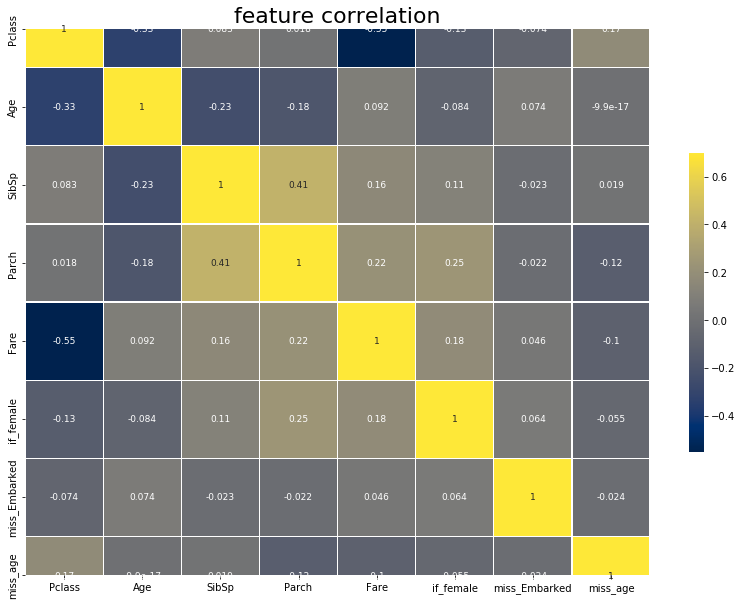

In [24]:
corr_matrix = x.corr()

corr_plot(corr_matrix, "feature correlation")

In [25]:
X_train,X_test,y_train,y_test=train_test_split(x, y, train_size = 0.7, random_state=412)
print(X_train.shape, X_test.shape)

lin_model = LinearRegression().fit(X_train, y_train)
y_pred_prob = lin_model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype('int')
score_prediction(y_test, y_pred)

(623, 8) (268, 8)
Accuracy:  0.806
Precision: 0.785
Recall:    0.695
F1:        0.737


### 5. Use zero values + missing_age feature

In [26]:
df_nonmiss = df_num.copy()
df_nonmiss['miss_age'] = df_nonmiss.Age.isna().astype('int')
df_nonmiss.loc[df_nonmiss.Age.isna(), 'Age'] = 0

y = df_nonmiss.pop(target)
x = df_nonmiss

df_nonmiss.tail()

,Pclass,Age,SibSp,Parch,Fare,if_female,miss_Embarked,miss_age
886,2,27.0000,0,0,13.0000,0,0,0
887,1,19.0000,0,0,30.0000,1,0,0
888,3,0.0000,1,2,23.4500,1,0,1
889,1,26.0000,0,0,30.0000,0,0,0
890,3,32.0000,0,0,7.7500,0,0,0


In [27]:
X_train,X_test,y_train,y_test=train_test_split(x, y, train_size = 0.7, random_state=412)
print(X_train.shape, X_test.shape)

lin_model = LinearRegression().fit(X_train, y_train)
y_pred_prob = lin_model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype('int')
score_prediction(y_test, y_pred)

(623, 8) (268, 8)
Accuracy:  0.806
Precision: 0.785
Recall:    0.695
F1:        0.737


In [28]:
lr_perm = PermutationImportance(lin_model, random_state=42).fit(X_test, y_test)
eli5.show_weights(lr_perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.5606 ± 0.0601,if_female
0.1615 ± 0.0231,Pclass
0.1127 ± 0.0433,Age
0.0201 ± 0.0146,SibSp
0.0189 ± 0.0165,miss_age
0.0049 ± 0.0033,Fare
0.0013 ± 0.0018,Parch
0.0008 ± 0.0010,miss_Embarked


### Let's investigate ROC_AUC

In [29]:
thresh_list = list(np.arange(0.0, 1.0, 0.01))
thresh_list[0:5]

[0.0, 0.01, 0.02, 0.03, 0.04]

#### More features model

In [30]:
df_nonmiss = df_num.copy()
# df_nonmiss.loc[1, 'Age']=100000
df_nonmiss['miss_age'] = df_nonmiss.Age.isna().astype('int')
age_mean = df_nonmiss.Age.mean()
df_nonmiss.loc[df_nonmiss.Age.isna(), 'Age'] = age_mean

y = df_nonmiss.pop(target)
x = df_nonmiss

In [31]:
X_train,X_test,y_train,y_test=train_test_split(x, y, train_size = 0.7, random_state=412)
print(X_train.shape, X_test.shape)

lin_model = LinearRegression().fit(X_train, y_train)
y_pred_prob = lin_model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype('int')
score_prediction(y_test, y_pred)

(623, 8) (268, 8)
Accuracy:  0.806
Precision: 0.785
Recall:    0.695
F1:        0.737


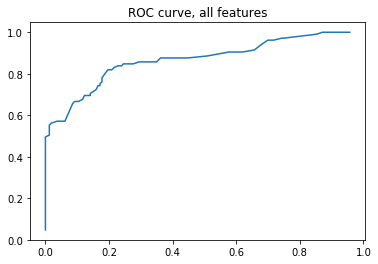

In [32]:
tpr_series = [tpr_thresh(thresh) for thresh in thresh_list]
fpr_series = [fpr_thresh(thresh) for thresh in thresh_list]

plt.plot(fpr_series, tpr_series)
plt.title('ROC curve, all features')
plt.show()

#### Simple model

In [33]:
df_nonmiss = df_num.copy()

y = df_nonmiss.pop(target)
x = df_nonmiss[['Pclass']]
X_train,X_test,y_train,y_test=train_test_split(x, y, train_size = 0.7, random_state=412)
print(X_train.shape, X_test.shape)

lin_model = LinearRegression().fit(X_train, y_train)
y_pred_prob = lin_model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype('int')
score_prediction(y_test, y_pred)

(623, 1) (268, 1)
Accuracy:  0.687
Precision: 0.667
Recall:    0.400
F1:        0.500


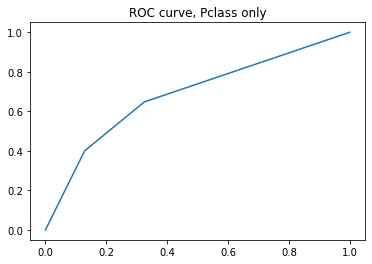

In [34]:
tpr_series_1 = [tpr_thresh(thresh) for thresh in thresh_list]
fpr_series_1 = [fpr_thresh(thresh) for thresh in thresh_list]

plt.plot(fpr_series_1, tpr_series_1)
plt.title('ROC curve, Pclass only')
plt.show()

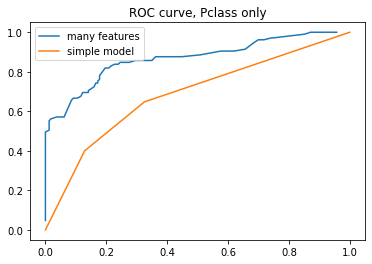

In [35]:
plt.plot(fpr_series, tpr_series, label='many features')
plt.plot(fpr_series_1, tpr_series_1, label='simple model')
plt.legend()
plt.title('ROC curve, Pclass only')
plt.show()

In [36]:
tpr_thresh(0.1), tpr_thresh(0.9)

(1.0, 0.0)

### How accuracy depends on threshold

In [37]:
def accuracy_thresh(thresh, y_test, y_pred_prob):
    y_pred = (y_pred_prob > thresh).astype('int')
    return accuracy_score(y_test, y_pred)

In [38]:
df_nonmiss = df_num.dropna(subset = ["Age"])

y = df_nonmiss.pop(target)
x = df_nonmiss
X_train,X_test,y_train,y_test=train_test_split(x, y, train_size = 0.7, random_state=412)

lin_model = LinearRegression().fit(X_train, y_train)
y_pred_prob = lin_model.predict(X_test)
lr_perm = PermutationImportance(lin_model, random_state=42).fit(X_test, y_test)
eli5.show_weights(lr_perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.5052 ± 0.1441,if_female
0.2590 ± 0.0863,Pclass
0.0881 ± 0.0418,Age
0.0291 ± 0.0121,SibSp
0.0006 ± 0.0090,miss_Embarked
0.0001 ± 0.0006,Fare
-0.0050 ± 0.0039,Parch


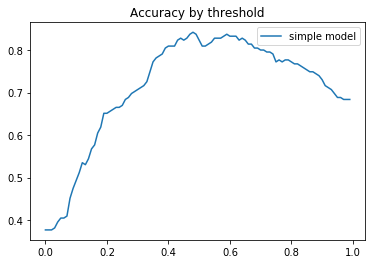

In [39]:
accuracy_series = [accuracy_thresh(thresh, y_test, y_pred_prob) for thresh in thresh_list]
plt.plot(thresh_list, accuracy_series, label='simple model')
plt.legend()
plt.title('Accuracy by threshold')
plt.show()

### HW 1: check (plot) precision_score, recall_score, f1_score for different threshold values

### Logistic Regression

Also called **logit** model

**probit** is similar logit, but uses Gaussian distribution instead of sigmoid function 

In [40]:
df_nonmiss = df_num.copy()
# df_nonmiss.loc[1, 'Age']=100000

y = df_nonmiss.pop(target)
x = df_nonmiss[['Pclass']]
X_train,X_test,y_train,y_test=train_test_split(x, y, train_size = 0.7, random_state=412)
print(X_train.shape, X_test.shape)

logit_model = LogisticRegression().fit(X_train, y_train)

(623, 1) (268, 1)


In [41]:
y_pred_prob = logit_model.predict_proba(X_test)
y_pred = (y_pred_prob[:,1] > 0.5).astype('int')
score_prediction(y_test, y_pred)

Accuracy:  0.687
Precision: 0.667
Recall:    0.400
F1:        0.500


### HW 2: test how sensitive is logistic and linear models to outliers

### HW 3: compare results from logit (logistic) and probit models (statsmodels.discrete.discrete_model.Probit)

## 2022-02-20

In [42]:
df = pd.read_csv('https://github.com/giedriusblazys/SDA_DS_class/raw/main/practice/input/titanic.csv')

df = df.drop(columns='PassengerId')
df['if_female'] = (df.Sex=='female').astype('int')
df['if_embarked_C'] = (df.Embarked=='C').astype('int')
df['if_embarked_Q'] = (df.Embarked=='Q').astype('int')
df['miss_Embarked'] = df.Embarked.isna().astype('int')

target = 'Survived'

df_num = df[df.columns[df.dtypes!='object']]

df_nonmiss = df_num.copy()
# df_nonmiss.loc[1, 'Age']=100000
df_nonmiss['miss_age'] = df_nonmiss.Age.isna().astype('int')
age_mean = df_nonmiss.Age.mean()
df_nonmiss.loc[df_nonmiss.Age.isna(), 'Age'] = age_mean

y = df_nonmiss[target]
x = df_nonmiss.drop(columns=[target])

X_train,X_test,y_train,y_test=train_test_split(x, y, train_size = 0.7, random_state=42, stratify=y)
print(X_train.shape, X_test.shape)
print(f'Survival rate in train dataset: {y_train.mean()}, in test dataset: {y_test.mean()}')

(623, 10) (268, 10)
Survival rate in train dataset: 0.38362760834670945, in test dataset: 0.3843283582089552


In [43]:
logit_model = LogisticRegression(penalty='none', max_iter=1000).fit(X_train, y_train)
y_pred = logit_model.predict(X_test)
score_prediction(y_test, y_pred)

Accuracy:  0.806
Precision: 0.768
Recall:    0.709
F1:        0.737


In [44]:
# #Try scaling
# x['if_female'] = x['if_female']*1000

# X_train,X_test,y_train,y_test=train_test_split(x, y, train_size = 0.7, random_state=412)
# logit_model_scaled = LogisticRegression(penalty='none', max_iter=1000).fit(X_train, y_train)
# y_pred = logit_model_scaled.predict(X_test)
# score_prediction(y_test, y_pred)

# logit_model.coef_[0][5], logit_model_scaled.coef_[0][5]

In [45]:
logit_model = LogisticRegression(penalty='l2', C=2, max_iter=1000).fit(X_train, y_train)
y_pred = logit_model.predict(X_test)
score_prediction(y_test, y_pred)

Accuracy:  0.799
Precision: 0.753
Recall:    0.709
F1:        0.730


In [46]:
logit_model = LogisticRegression(penalty='l1', C=1, solver='liblinear', max_iter=1000).fit(X_train, y_train)
y_pred = logit_model.predict(X_test)
score_prediction(y_test, y_pred)

Accuracy:  0.791
Precision: 0.747
Recall:    0.689
F1:        0.717


In [47]:
logit_model = LogisticRegression(penalty='elasticnet', C=2, l1_ratio=0.9, solver='saga', max_iter=10000).fit(X_train, y_train)
y_pred = logit_model.predict(X_test)
score_prediction(y_test, y_pred)

Accuracy:  0.791
Precision: 0.783
Recall:    0.631
F1:        0.699


In [48]:
logit_model = LogisticRegression(penalty='l2', C=2, max_iter=1000).fit(X_train, y_train)
y_pred = logit_model.predict(X_test)
score_prediction(y_test, y_pred)

Accuracy:  0.799
Precision: 0.753
Recall:    0.709
F1:        0.730


### Decision Trees 

In [49]:
tree_model = DecisionTreeClassifier(random_state=42, max_depth=4, min_samples_split=5).fit(X_train, y_train)
y_pred = tree_model.predict(X_test)
score_prediction(y_test, y_pred)

Accuracy:  0.795
Precision: 0.864
Recall:    0.553
F1:        0.675


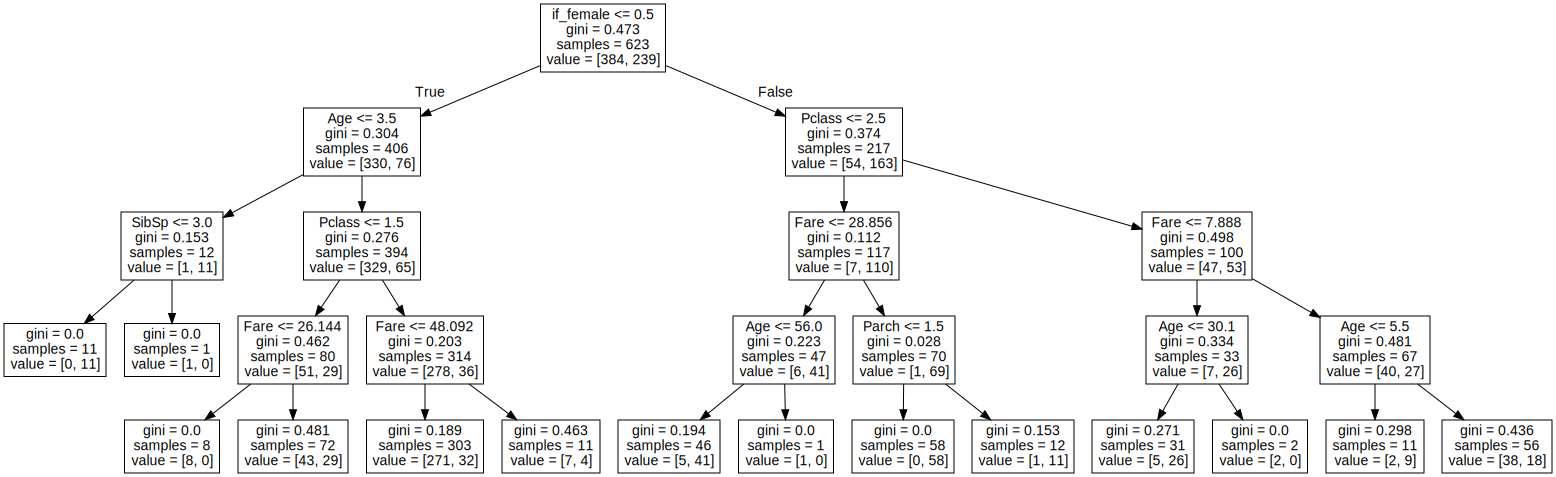

In [50]:
tree_graph = tree.export_graphviz(tree_model, out_file=None, feature_names=x.columns)
graphviz.Source(tree_graph)

In [51]:
x.head(10)

,Pclass,Age,SibSp,Parch,Fare,if_female,if_embarked_C,if_embarked_Q,miss_Embarked,miss_age
0,3,22.0000,1,0,7.2500,0,0,0,0,0
1,1,38.0000,1,0,71.2833,1,1,0,0,0
2,3,26.0000,0,0,7.9250,1,0,0,0,0
3,1,35.0000,1,0,53.1000,1,0,0,0,0
4,3,35.0000,0,0,8.0500,0,0,0,0,0
5,3,29.6991,0,0,8.4583,0,0,1,0,1
6,1,54.0000,0,0,51.8625,0,0,0,0,0
7,3,2.0000,3,1,21.0750,0,0,0,0,0
8,3,27.0000,0,2,11.1333,1,0,0,0,0
9,2,14.0000,1,0,30.0708,1,1,0,0,0


### Normalization (Standardization)

#### MinMax scaling

In [52]:
y = df_nonmiss[target]
x = df_nonmiss.drop(columns=[target])

x_scaled = x.copy()

for var in x.columns:
    x_scaled[var] =  (x[var] - x[var].min())/(x[var].max() - x[var].min()) 

X_train,X_test,y_train,y_test=train_test_split(x_scaled, y, train_size = 0.7, random_state=412)

In [53]:
logit_model = LogisticRegression(penalty='l2', C=1.5).fit(X_train, y_train)
y_pred = logit_model.predict(X_test)
score_prediction(y_test, y_pred)

Accuracy:  0.821
Precision: 0.794
Recall:    0.733
F1:        0.762


In [54]:
y = df_nonmiss[target]
x = df_nonmiss.drop(columns=[target])

X_train,X_test,y_train,y_test=train_test_split(x, y, train_size = 0.7, random_state=412)

In [55]:
min_max_scaler = preprocessing.MinMaxScaler()
X_train_minmax = min_max_scaler.fit_transform(X_train)
X_test_minmax = min_max_scaler.transform(X_test)

logit_model = LogisticRegression(penalty='l2', C=1.5).fit(X_train_minmax, y_train)
y_pred = logit_model.predict(X_test_minmax)
score_prediction(y_test, y_pred)

Accuracy:  0.821
Precision: 0.794
Recall:    0.733
F1:        0.762


In [56]:
tree_model = DecisionTreeClassifier(random_state=42, max_depth=16, min_samples_split=5).fit(X_train_minmax, y_train)
y_pred = tree_model.predict(X_test_minmax)
score_prediction(y_test, y_pred)

Accuracy:  0.784
Precision: 0.758
Recall:    0.657
F1:        0.704


#### Standard scaling

Optimal strength of penalty is different depending on type of scaling

In [57]:
std_scaler = preprocessing.StandardScaler()
X_train_std = std_scaler.fit_transform(X_train)
X_test_std = std_scaler.transform(X_test)

logit_model = LogisticRegression(penalty='l2', C=0.08).fit(X_train_std, y_train)
y_pred = logit_model.predict(X_test_std)
score_prediction(y_test, y_pred)

Accuracy:  0.821
Precision: 0.800
Recall:    0.724
F1:        0.760


In [58]:
pd.DataFrame(X_train_std, columns = x.columns).mean()

Pclass           0.0000
Age             -0.0000
SibSp            0.0000
Parch           -0.0000
Fare            -0.0000
if_female        0.0000
if_embarked_C   -0.0000
if_embarked_Q    0.0000
miss_Embarked   -0.0000
miss_age        -0.0000
dtype: float64

In [59]:
pd.DataFrame(X_train_std, columns = x.columns).std()

Pclass          1.0008
Age             1.0008
SibSp           1.0008
Parch           1.0008
Fare            1.0008
if_female       1.0008
if_embarked_C   1.0008
if_embarked_Q   1.0008
miss_Embarked   1.0008
miss_age        1.0008
dtype: float64

### Binning (Discretization)

#### Manual binning continuous variables to meaningful categories

In [60]:
y = df_nonmiss[target]
x = df_nonmiss.drop(columns=[target])
x['infant'] = (x.Age < 2).astype('int')
x['child'] = ((x.Age >= 2) & (x.Age < 14)).astype('int')
x['youth'] = ((x.Age >= 14) & (x.Age < 21)).astype('int')
x['adult'] = ((x.Age >= 21) & (x.Age < 50)).astype('int')
x['senior'] = ((x.Age >= 50)).astype('int')
x.drop(columns=['Age'], inplace=True)
x.tail()

,Pclass,SibSp,Parch,Fare,if_female,if_embarked_C,if_embarked_Q,miss_Embarked,miss_age,infant,child,youth,adult,senior
886,2,0,0,13.0000,0,0,0,0,0,0,0,0,1,0
887,1,0,0,30.0000,1,0,0,0,0,0,0,1,0,0
888,3,1,2,23.4500,1,0,0,0,1,0,0,0,1,0
889,1,0,0,30.0000,0,1,0,0,0,0,0,0,1,0
890,3,0,0,7.7500,0,0,1,0,0,0,0,0,1,0


In [61]:
X_train,X_test,y_train,y_test=train_test_split(x, y, train_size = 0.7, random_state=412)
min_max_scaler = preprocessing.MinMaxScaler()
X_train_minmax = min_max_scaler.fit_transform(X_train)
X_test_minmax = min_max_scaler.transform(X_test)

In [62]:
logit_model = LogisticRegression(penalty='l2', C=1.5).fit(X_train_minmax, y_train)
y_pred = logit_model.predict(X_test_minmax)
score_prediction(y_test, y_pred)

Accuracy:  0.828
Precision: 0.798
Recall:    0.752
F1:        0.775


In [63]:
tree_model = DecisionTreeClassifier(random_state=42, max_depth=16, min_samples_split=5).fit(X_train_minmax, y_train)
y_pred = tree_model.predict(X_test_minmax)
score_prediction(y_test, y_pred)

Accuracy:  0.858
Precision: 0.894
Recall:    0.724
F1:        0.800


#### Uniform transformation - ordinal encoding

![discretization](input/sphx_glr_plot_discretization_strategies_001.png)

In [69]:
y = df_nonmiss[target]
x = df_nonmiss.drop(columns=[target])

transf = preprocessing.KBinsDiscretizer(n_bins = 5, encode = 'ordinal', strategy = 'uniform')

features_to_bin = ['Age', 'Fare']
# features_to_bin = ['Age']

data_binned = transf.fit_transform(x[features_to_bin])

x[features_to_bin] = data_binned
x.head()

,Pclass,Age,SibSp,Parch,Fare,if_female,if_embarked_C,if_embarked_Q,miss_Embarked,miss_age
0,3,1.0000,1,0,0.0000,0,0,0,0,0
1,1,2.0000,1,0,0.0000,1,1,0,0,0
2,3,1.0000,0,0,0.0000,1,0,0,0,0
3,1,2.0000,1,0,0.0000,1,0,0,0,0
4,3,2.0000,0,0,0.0000,0,0,0,0,0


In [70]:
X_train,X_test,y_train,y_test=train_test_split(x, y, train_size = 0.7, random_state=412)
min_max_scaler = preprocessing.MinMaxScaler()
X_train_minmax = min_max_scaler.fit_transform(X_train)
X_test_minmax = min_max_scaler.transform(X_test)

In [71]:
logit_model = LogisticRegression(penalty='l2', C=1.5).fit(X_train_minmax, y_train)
y_pred = logit_model.predict(X_test_minmax)
score_prediction(y_test, y_pred)

Accuracy:  0.817
Precision: 0.792
Recall:    0.724
F1:        0.756


#### Uniform transformation - one-hot encoding

In [84]:
y = df_nonmiss[target]
x = df_nonmiss.drop(columns=[target])

transf = preprocessing.KBinsDiscretizer(n_bins = 5, encode = 'onehot', strategy = 'uniform')

# features_to_bin = ['Age', 'Fare']
features_to_bin = ['Age', 'Fare']

X_train_array = transf.fit_transform(X_train[features_to_bin]).toarray()
OH_cols_train = pd.DataFrame(X_train_array, columns = transf.get_feature_names_out())
X_test_array = transf.transform(X_test[features_to_bin]).toarray()
OH_cols_test = pd.DataFrame(X_test_array, columns = transf.get_feature_names_out())
OH_cols_train.index = X_train.index
OH_cols_test.index = X_test.index

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = X_train.drop(features_to_bin, axis=1)
num_X_test = X_test.drop(features_to_bin, axis=1)

# Add one-hot encoded columns to numerical features
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_test = pd.concat([num_X_test, OH_cols_test], axis=1)
OH_X_train.head()

,Pclass,SibSp,Parch,if_female,if_embarked_C,if_embarked_Q,miss_Embarked,miss_age,Age_0.0,Age_1.0,Age_2.0,Age_3.0,Age_4.0,Fare_0.0,Fare_1.0,Fare_2.0,Fare_3.0,Fare_4.0
858,3,0,3,1,1,0,0,0,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000
66,2,0,0,1,0,0,0,0,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000
245,1,2,0,0,0,1,0,0,0.0000,0.0000,1.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000
140,3,0,2,1,1,0,0,1,0.0000,1.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000
366,1,1,0,1,1,0,0,0,0.0000,0.0000,0.0000,1.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000


In [85]:
min_max_scaler = preprocessing.MinMaxScaler()
X_train_minmax = min_max_scaler.fit_transform(OH_X_train)
X_test_minmax = min_max_scaler.transform(OH_X_test)

logit_model = LogisticRegression(penalty='l2', C=1.5).fit(X_train_minmax, y_train)
y_pred = logit_model.predict(X_test_minmax)
score_prediction(y_test, y_pred)

Accuracy:  0.821
Precision: 0.806
Recall:    0.714
F1:        0.758


In [86]:
tree_model = DecisionTreeClassifier(random_state=42, max_depth=16, min_samples_split=5).fit(X_train_minmax, y_train)
y_pred = tree_model.predict(X_test_minmax)
score_prediction(y_test, y_pred)

Accuracy:  0.795
Precision: 0.829
Recall:    0.600
F1:        0.696


#### Quantile transformation

Create bins with equal or similar number of records (values)

In [91]:
y = df_nonmiss[target]
x = df_nonmiss.drop(columns=[target])

transf = preprocessing.KBinsDiscretizer(n_bins = 5, encode = 'ordinal', strategy = 'quantile')

# features_to_bin = ['Age', 'Fare']
features_to_bin = ['Age']

data_binned = transf.fit_transform(x[features_to_bin])

x[features_to_bin] = data_binned
x.head()

,Pclass,Age,SibSp,Parch,Fare,if_female,if_embarked_C,if_embarked_Q,miss_Embarked,miss_age
0,3,1.0000,1,0,7.2500,0,0,0,0,0
1,1,4.0000,1,0,71.2833,1,1,0,0,0
2,3,1.0000,0,0,7.9250,1,0,0,0,0
3,1,3.0000,1,0,53.1000,1,0,0,0,0
4,3,3.0000,0,0,8.0500,0,0,0,0,0


In [92]:
X_train,X_test,y_train,y_test=train_test_split(x, y, train_size = 0.7, random_state=412)
min_max_scaler = preprocessing.MinMaxScaler()
X_train_minmax = min_max_scaler.fit_transform(X_train)
X_test_minmax = min_max_scaler.transform(X_test)

In [93]:
logit_model = LogisticRegression(penalty='l2', C=1.5).fit(X_train_minmax, y_train)
y_pred = logit_model.predict(X_test_minmax)
score_prediction(y_test, y_pred)

Accuracy:  0.828
Precision: 0.817
Recall:    0.724
F1:        0.768


In [94]:
x.Age.value_counts()

3.0000    319
4.0000    188
1.0000    173
0.0000    164
2.0000     47
Name: Age, dtype: int64